Import Library

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

Read Dataset

In [7]:
feature_train_path = os.path.join("..", "data", "raw", "dengue_features_train.csv")
feature_test_path = os.path.join("..", "data", "raw", "dengue_features_test.csv")
outcome_train_path = os.path.join("..", "data", "raw", "dengue_labels_train.csv")
feature_train = pd.read_csv(feature_train_path, parse_dates=["week_start_date"])
feature_test = pd.read_csv(feature_test_path, parse_dates=["week_start_date"])
outcome_train = pd.read_csv(outcome_train_path)
df = pd.merge(feature_train, outcome_train, on=["city", "year", "weekofyear"], how="inner")

Feature Engineering

<Axes: >

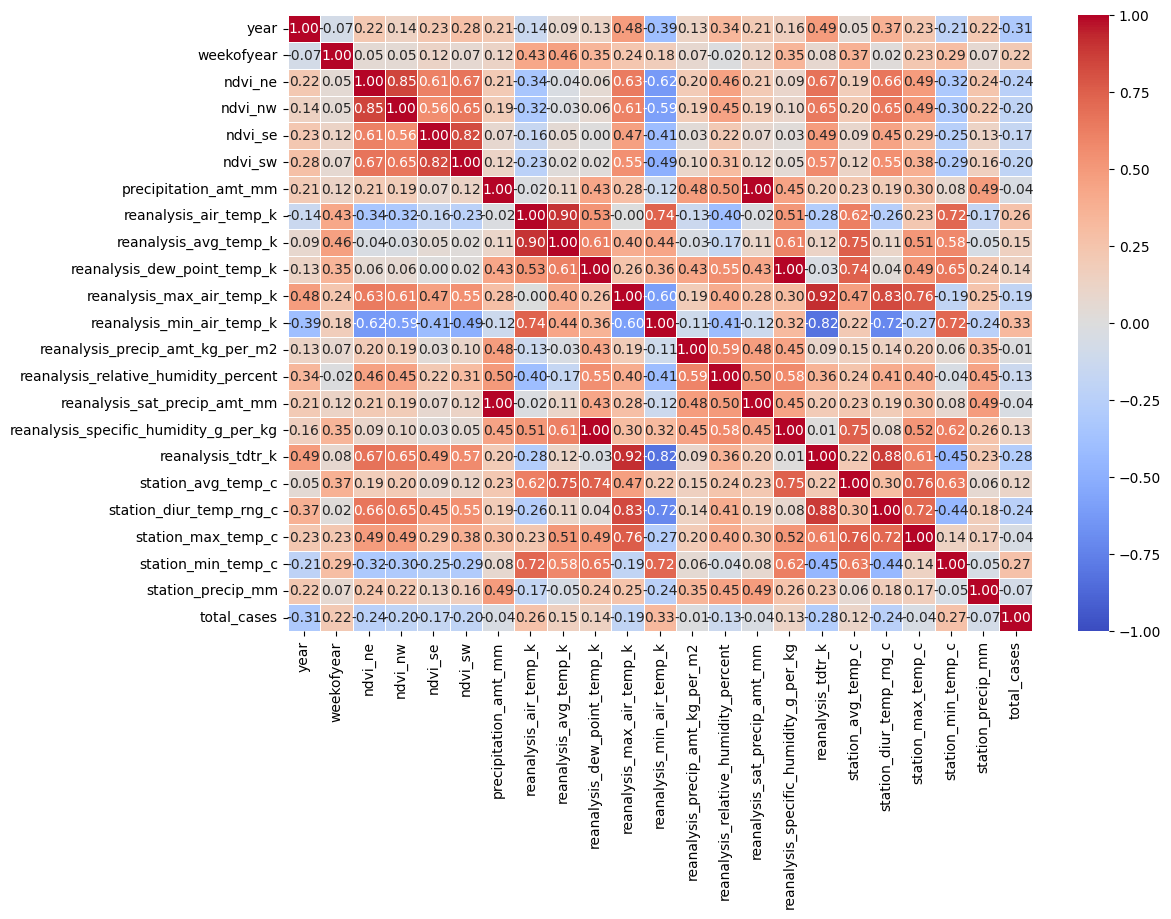

In [8]:
corr_matrix_train = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix_train,   
    annot=True,            
    cmap="coolwarm",       
    fmt=".2f",             
    linewidths=0.5,        
    vmin=-1, vmax=1        
)

<Axes: >

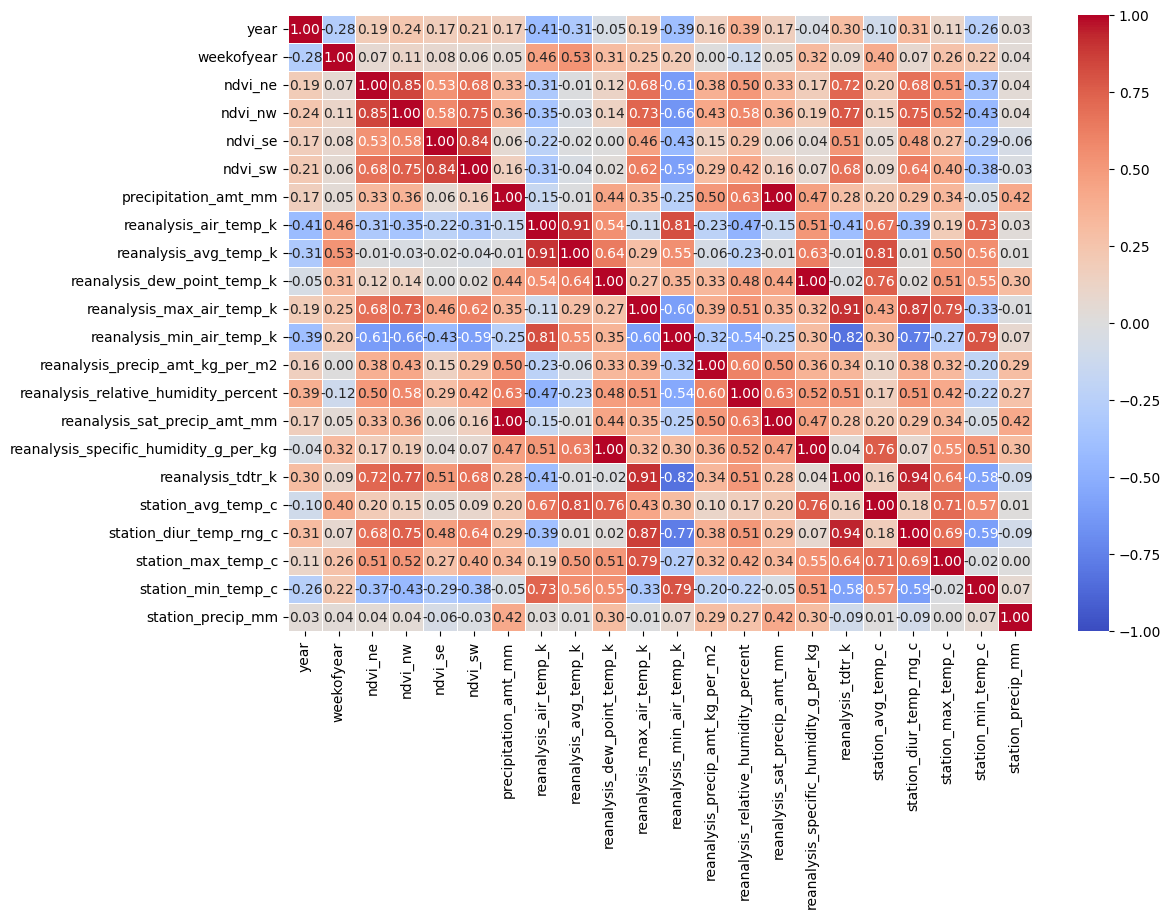

In [9]:
corr_matrix_test = feature_test.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix_test,   
    annot=True,            
    cmap="coolwarm",       
    fmt=".2f",             
    linewidths=0.5,        
    vmin=-1, vmax=1        
)

In [10]:
#Drop "precipitation_amt_mm" column
df = df.drop("precipitation_amt_mm", axis=1)
feature_test = feature_test.drop("precipitation_amt_mm", axis=1)

In [11]:
#Merge "reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k" by using PCA
cols = ["reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k"]
mask = df[cols].isna().any(axis=1)
df_complete = df[~mask].copy()
df_incomplete = df[mask].copy()
pca = PCA(n_components=1)
pca_features = pca.fit_transform(df_complete[cols])
df_pca = pd.DataFrame(pca_features, columns=["dew_humidity"], index=df_complete.index)
df["dew_humidity"] = np.nan
df.loc[df_pca.index, ["dew_humidity"]] = df_pca
df = df.drop(cols,axis=1)
df = df[df.columns[:-2].tolist() + [df.columns[-1], df.columns[-2]]]

mask_test = feature_test[cols].isna().any(axis=1)
feature_test_complete = feature_test[~mask_test].copy()
feature_test_incomplete = feature_test[mask_test].copy()
pca_features_test = pca.fit_transform(feature_test_complete[cols])
feature_test_pca = pd.DataFrame(pca_features_test, columns=["dew_humidity"], index=feature_test_complete.index)
feature_test["dew_humidity"] = np.nan
feature_test.loc[feature_test_pca.index, ["dew_humidity"]] = feature_test_pca
feature_test = feature_test.drop(cols,axis=1)
feature_test = feature_test[feature_test.columns[:-2].tolist() + [feature_test.columns[-1], feature_test.columns[-2]]]

Split Dataset by City

In [12]:
city_groups = df.groupby("city")
sj_past = city_groups.get_group("sj")
iq_past = city_groups.get_group("iq")

city_groups_test = feature_test.groupby("city")
sj_future = city_groups_test.get_group("sj")
iq_future = city_groups_test.get_group("iq")

<Axes: >

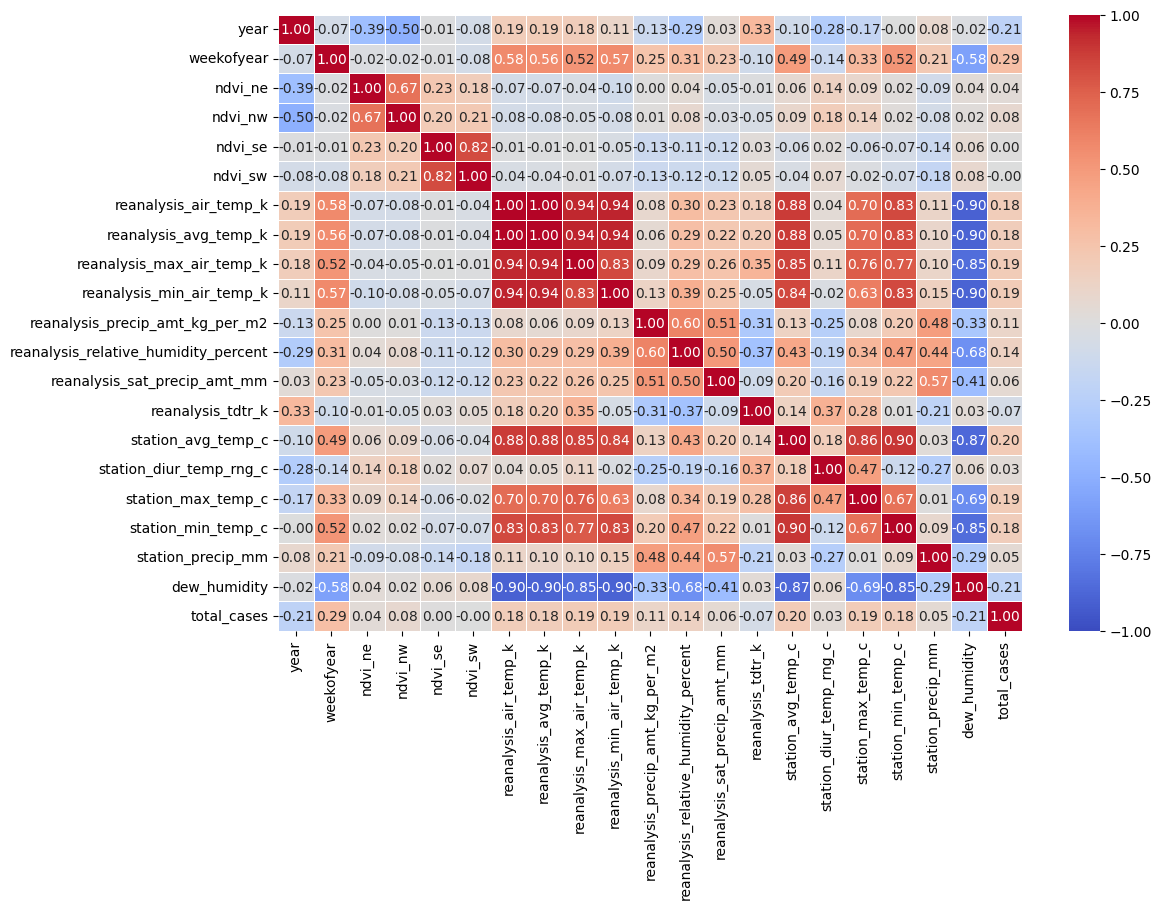

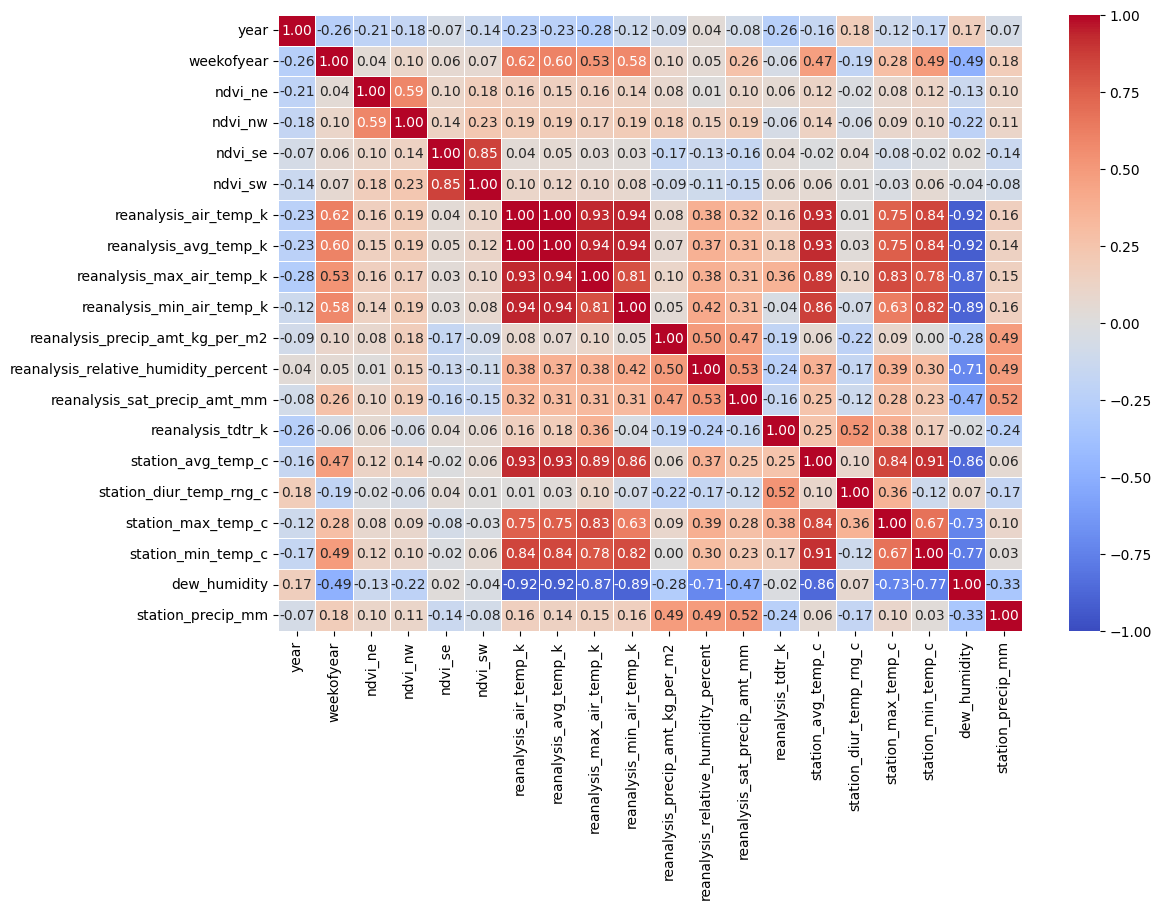

In [13]:
corr_matrix_sj_train = sj_past.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix_sj_train,   
    annot=True,            
    cmap="coolwarm",       
    fmt=".2f",             
    linewidths=0.5,        
    vmin=-1, vmax=1        
)
corr_matrix_sj_test = sj_future.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix_sj_test,   
    annot=True,            
    cmap="coolwarm",       
    fmt=".2f",             
    linewidths=0.5,        
    vmin=-1, vmax=1        
)

<Axes: >

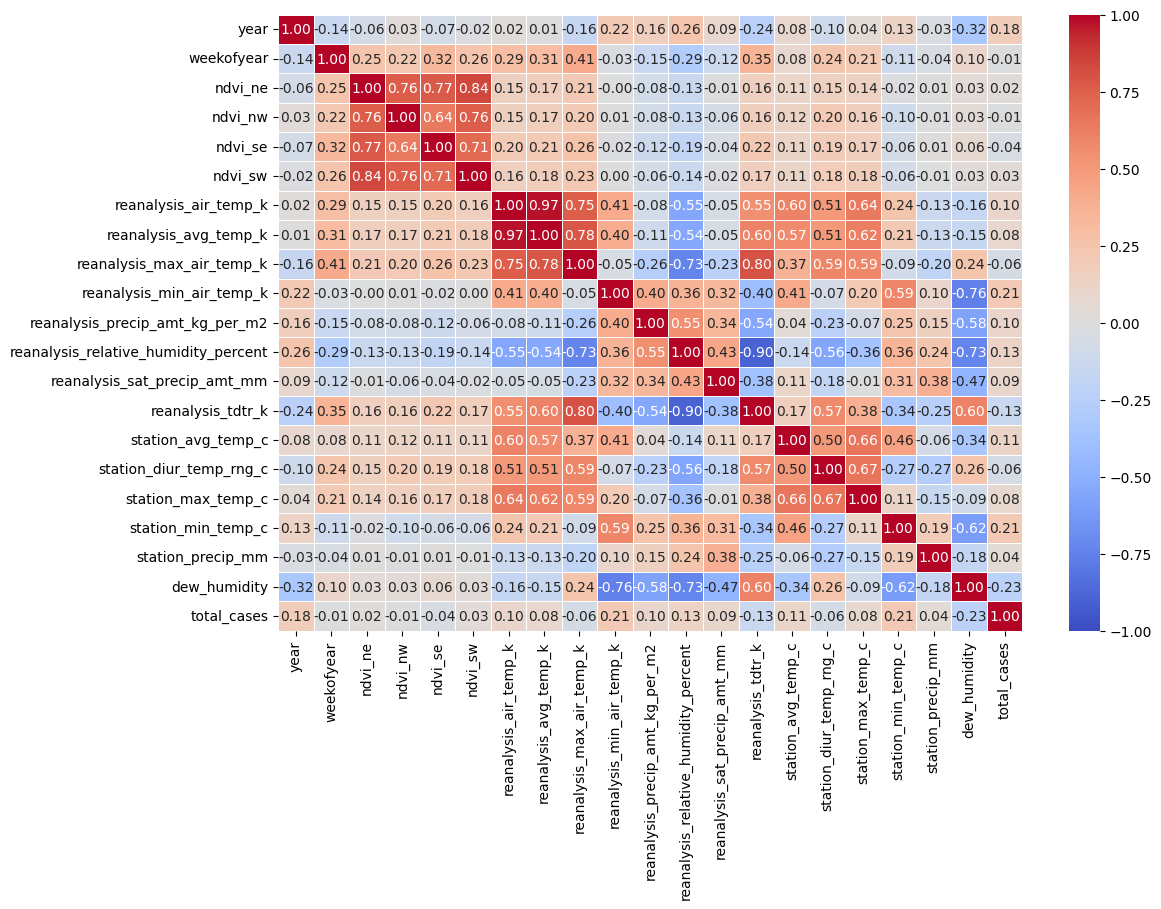

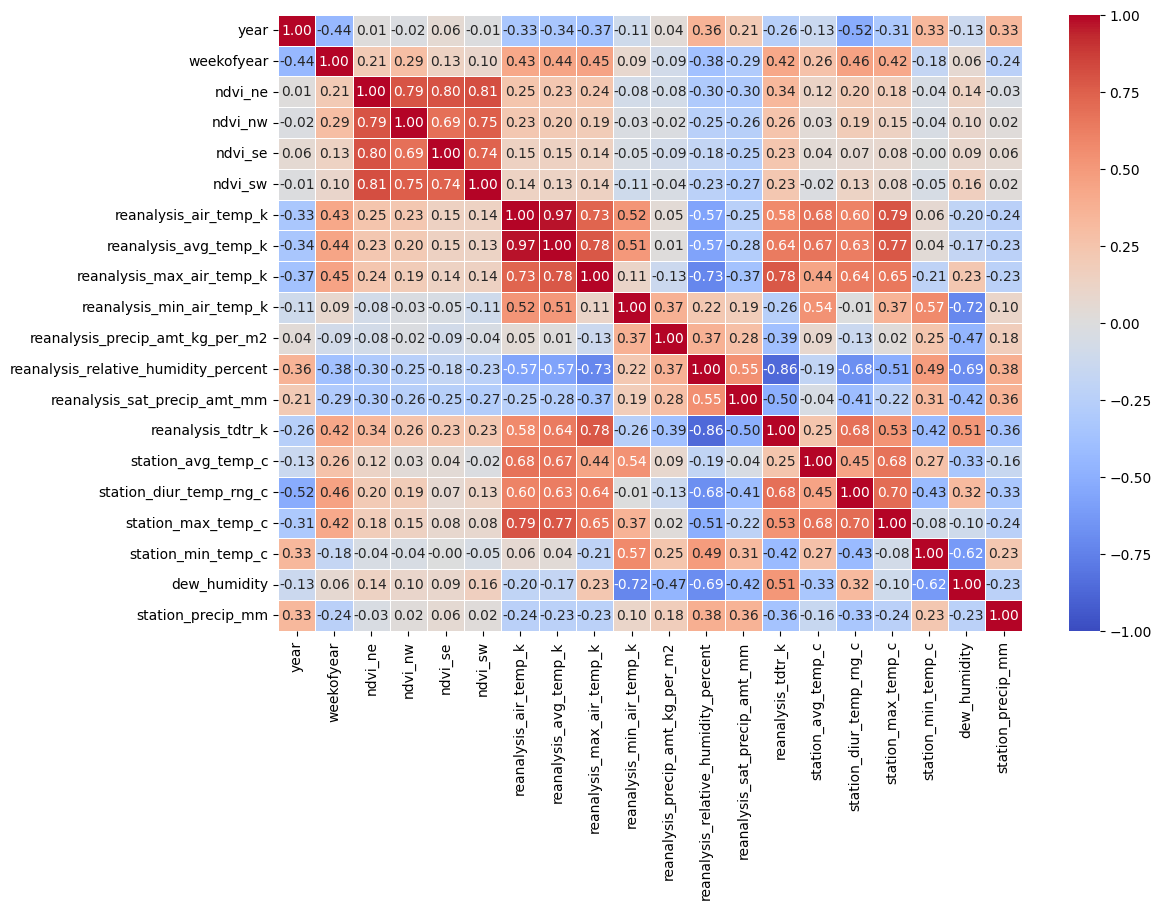

In [14]:
corr_matrix_iq_train = iq_past.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix_iq_train,   
    annot=True,            
    cmap="coolwarm",       
    fmt=".2f",             
    linewidths=0.5,        
    vmin=-1, vmax=1        
)
corr_matrix_iq_test = iq_future.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix_iq_test,   
    annot=True,            
    cmap="coolwarm",       
    fmt=".2f",             
    linewidths=0.5,        
    vmin=-1, vmax=1        
)

Impute Missing Data and Write in csv

In [15]:
imputer = IterativeImputer(max_iter=10)
cols = ['ndvi_ne', 'ndvi_nw', 'station_diur_temp_rng_c', "station_avg_temp_c", "ndvi_se", "ndvi_sw", "station_precip_mm", "station_max_temp_c", "station_min_temp_c", "reanalysis_sat_precip_amt_mm", "reanalysis_relative_humidity_percent", "reanalysis_tdtr_k", "reanalysis_min_air_temp_k", "reanalysis_precip_amt_kg_per_m2", "reanalysis_max_air_temp_k", "reanalysis_avg_temp_k", "reanalysis_air_temp_k", "dew_humidity"]
sj_past[cols] = imputer.fit_transform(sj_past[cols])
iq_past[cols] = imputer.fit_transform(iq_past[cols])
sj_future[cols] = imputer.fit_transform(sj_future[cols])
iq_future[cols] = imputer.fit_transform(iq_future[cols])

current_dir = os.getcwd()
processed_dir = os.path.join(os.path.dirname(current_dir), "data", "processed")

sj_past.to_csv(os.path.join(processed_dir, "sj_past.csv"), index=False)
sj_future.to_csv(os.path.join(processed_dir, "sj_future.csv"), index=False)
iq_past.to_csv(os.path.join(processed_dir, "iq_past.csv"), index=False)
iq_future.to_csv(os.path.join(processed_dir, "iq_future.csv"), index=False)

C:\Users\13084\AppData\Local\Temp\ipykernel_28160\2652198650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_past[cols] = imputer.fit_transform(sj_past[cols])
C:\Users\13084\AppData\Local\Temp\ipykernel_28160\2652198650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iq_past[cols] = imputer.fit_transform(iq_past[cols])
C:\Users\13084\AppData\Local\Temp\ipykernel_28160\2652198650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in